In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
torch.manual_seed(0)

In [2]:
data = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv")
data = data.iloc[:,1:53]
data.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,11,12,10,8,13,12,14,21,6,14,...,4,7,8,10,12,3,7,6,5,10
1,7,6,3,2,7,1,6,3,3,3,...,2,4,5,1,1,4,5,1,6,0
2,7,11,8,9,10,8,7,13,12,6,...,6,14,5,5,7,8,14,8,8,7
3,12,8,13,5,9,6,9,13,13,11,...,9,10,3,4,6,8,14,8,7,8
4,8,5,13,11,6,7,9,14,9,9,...,7,11,7,12,6,6,5,11,8,9


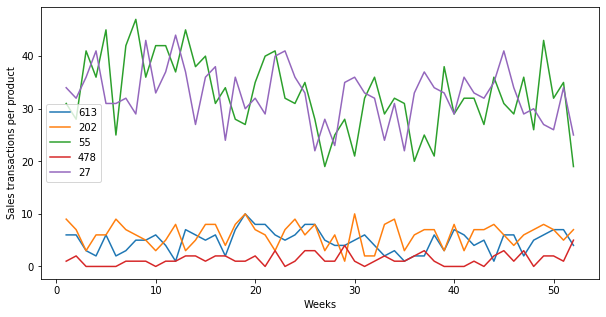

In [3]:
plot_data = data.sample(5, random_state=0)
x = range(1,53)

plt.figure(figsize=(10,5))

for i,row in plot_data.iterrows():
    plt.plot(x,row)

plt.legend(plot_data.index)
plt.xlabel("Weeks")
plt.ylabel("Sales transactions per product")
plt.show()

In [4]:
data_train = data.iloc[:,:-1]
inputs = torch.Tensor(data_train.values).unsqueeze(1)
targets = data_train.shift(-1, axis="columns", fill_value=data.iloc[:,-1]).astype(dtype = "float32")
targets = torch.Tensor(targets.values)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_size)
        out = self.output(out)
        
        return out, hidden

In [6]:
model = RNN(data_train.shape[1], 10, 1)
model

RNN(
  (rnn): RNN(51, 10, batch_first=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [7]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

In [8]:
losses = []
for i in range(1, epochs+1):
    
    hidden = None
    pred, hidden = model(inputs, hidden)
    target = targets[:,-1].unsqueeze(1)
    
    loss = loss_function(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i%1000 == 0:
        print("epoch: ", i, "... Loss function: ", losses[-1])

epoch:  1000 ... Loss function:  58.48879623413086
epoch:  2000 ... Loss function:  24.934917449951172
epoch:  3000 ... Loss function:  13.247632026672363
epoch:  4000 ... Loss function:  9.884735107421875
epoch:  5000 ... Loss function:  8.778228759765625
epoch:  6000 ... Loss function:  8.025042533874512
epoch:  7000 ... Loss function:  7.622503757476807
epoch:  8000 ... Loss function:  7.4796295166015625
epoch:  9000 ... Loss function:  7.351718902587891
epoch:  10000 ... Loss function:  7.311776161193848


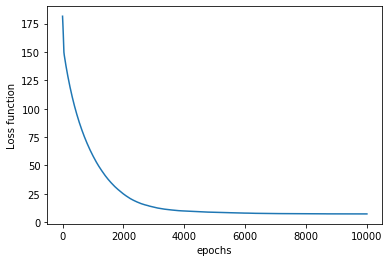

In [9]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

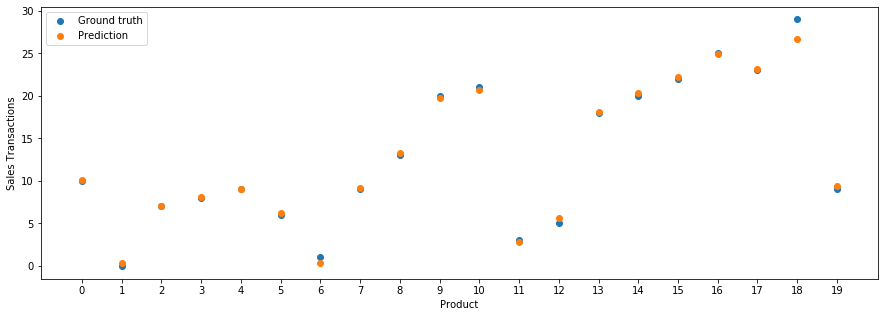

In [10]:
x_range = range(len(data))
target = data.iloc[:,-1].values.reshape(len(data),1)
plt.figure(figsize=(15,5))
plt.scatter(x_range[:20], target[:20])
plt.scatter(x_range[:20], pred.detach().numpy()[:20])
plt.legend(["Ground truth", "Prediction"])
plt.xlabel("Product")
plt.ylabel("Sales Transactions")
plt.xticks(range(0, 20))
plt.show()